# Accuracy of global temporal analysis as dependent on stack length vs oscillation period

## Preparation
Import of required modules and packages.

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from IPython.display import clear_output

from min_analysis_tools import correlation_tools

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

plt.rc("font", size=10)  # controls default text size
plt.rcParams.update({"font.family": "arial"})

In [ ]:
# save set to True -> selected images saved to save_output
save = False
save_dpi = 150
cm = 1 / 2.54  # centimeters in inches (for matplotlib figure size)

## Selection

Select input path:

In [2]:
stack_path = Path().cwd() / "example_data" / "accuracy_test.tif"

Select parameters:

In [3]:
reps_per_kymostack = 10  # pick ... kymographs around middle (integer number)
kymoband = 0.8  # analyse middle ... part of image (< 1, default: 0.8)

Load image:

In [4]:
Min_st = io.imread(stack_path)
nt, ny, nx = np.shape(Min_st)

Cut-off stack lengths:

In [5]:
cut_off_lengths = list(range(12, nt, 2))  # select max stack lengths
cut_off_lengths.reverse()  # reverse list to start with longest

Display image:

Current reps_per_kymostack: 10
Current kymoband: 0.8
Current file: size: 1425 pixels x 1425 pixels x 25 frames


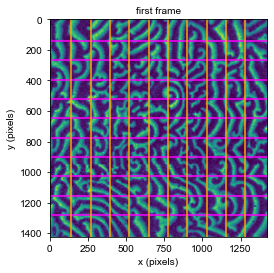

In [6]:
# print stack information
print(f"Current reps_per_kymostack: {reps_per_kymostack}")
print(f"Current kymoband: {kymoband}")
print(f"Current file: size: {nx} pixels x {ny} pixels x {nt} frames")

# define slices to analyse
slices2analyze_x = ny * np.linspace(
    0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
)
slices2analyze_x = slices2analyze_x.astype(int)

slices2analyze_y = nx * np.linspace(
    0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
)
slices2analyze_y = slices2analyze_y.astype(int)

# plot image and slices for analysis
fig, ax = plt.subplots(1, 1)
ax.imshow(Min_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("first frame", fontsize=10)
for y_axis in slices2analyze_x:
    ax.axhline(y=y_axis, color="magenta", linewidth=1.5)
for x_axis in slices2analyze_y:
    ax.axvline(x=x_axis, color="orange", linewidth=1.5)

if save:
    fig.set_size_inches(7 * cm, 7 * cm)
    fig.tight_layout()
    fig.savefig(
        r"save_output\global_temporal_kymobands.png", dpi=save_dpi, transparent=True
    )
plt.show()

Smoothed image: (both original and smoothed will be analyzed)

In [ ]:
smz = 40

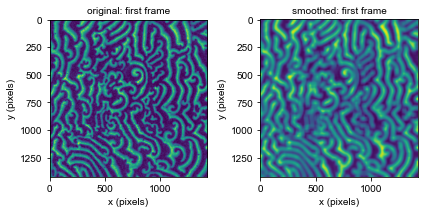

In [7]:
Min_st_smz = np.empty((nt, ny, nx))
smz_kernel = np.ones((smz, smz), np.float32) / (smz**2)
for frame in np.arange(nt):
    img = Min_st[frame, :, :]
    img_smz = cv2.filter2D(img, -1, smz_kernel)
    Min_st_smz[frame, :, :] = img_smz

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Min_st[0, :, :])
ax1.set_xlabel("x (pixels)")
ax1.set_ylabel("y (pixels)")
ax1.set_title("original: first frame", fontsize=10)

ax2.imshow(Min_st_smz[0, :, :])
ax2.set_xlabel("x (pixels)")
ax2.set_ylabel("y (pixels)")
ax2.set_title("smoothed: first frame", fontsize=10)

fig.tight_layout()
if save:
    fig.set_size_inches(11 * cm, 7 * cm)
    fig.tight_layout()
    fig.savefig(
        r"save_output\global_temporal_smooth_comparison.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()

## Temporal autocorrelation
For temporal correlation, we generate a set of $t$-$x$ or $t$-$y$ kymographs per movie, evenly distributed over a set middle fraction fraction of an image. For each set of kymographs, autocorrelation analysis is performed. The $\Delta x$=0 or $\Delta y$=0 line of the resulting autocorrelation maps then in effect represent a temporal correlation curve averaged over all the original image points on this line. In other words, they represent average temporal correlation signals sampled from all selected surface locations. The first maximum after  $\Delta t=0$ indicates a main oscillation period.

In [8]:
def temporal_autocorrelation(MinDE_st, slices2analyze_x, slices2analyze_y):

    nt, ny, nx = np.shape(MinDE_st)
    title = f"stack length: {nt} frames"

    # reslice frames
    MinDE_shift_tx = np.moveaxis(MinDE_st, 0, -1)  # creates t-x resliced frames
    MinDE_shift_yt = np.moveaxis(MinDE_st, -1, 0)  # creates y-t resliced frames

    # next transpose y-t slices to have t axis in 1st dimension
    MinDE_shift_ty = np.empty((nx, ny, nt))
    for frame in range(nx):
        MinDE_shift_ty[frame, :, :] = np.transpose(MinDE_shift_yt[frame, :, :])

    (
        crmx_storage_x,
        slices2analyze,
    ) = correlation_tools.get_temporal_correlation_matrixes(
        MinDE_shift_tx,
        "x",
        kymoband,
        reps_per_kymostack,
        demo=False,
    )
    (
        first_min_pos_x,
        first_min_val_x,
        first_max_pos_x,
        first_max_val_x,
        fig,
        ax,
    ) = correlation_tools.analyze_temporal_profiles(
        "x", crmx_storage_x, slices2analyze_x, demo=True
    )
    ax.set_title(title, fontsize=10)
    plt.show()

    (
        crmx_storage_y,
        slices2analyze_y,
    ) = correlation_tools.get_temporal_correlation_matrixes(
        MinDE_shift_ty,
        "y",
        kymoband,
        reps_per_kymostack,
        demo=False,
    )
    (
        first_min_pos_y,
        first_min_val_y,
        first_max_pos_y,
        first_max_val_y,
    ) = correlation_tools.analyze_temporal_profiles(
        "y", crmx_storage_y, slices2analyze_y, demo=False
    )

    all_minima = np.append(first_min_pos_x, first_min_pos_y)
    all_maxima = np.append(first_max_pos_x, first_max_pos_y)

    period = np.mean(all_maxima)
    period_std = np.std(all_maxima)
    print("")
    print(
        f"Position of first valley: ({np.mean(all_minima):.02f} ± {np.std(all_minima):.02f}) frames"
    )
    print(f"Oscillation period: ({period:.02f} ± {period_std:.02f}) frames")
    print("")

    return period, period_std, fig, ax

### Temporal autocorrelation for entire stack
First, analyse the entire image stack. The oscillation period obtained from the full stack will be considered the most accurate, and hence be referred to as reference oscillation period $\tau_{ref}$.

Original image stack:
Analyzing t-x slices for y = [ 142  269  395  522  649  775  902 1029 1155 1282]


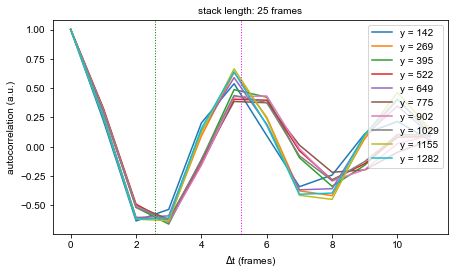

Analyzing t-y slices for x = [ 142  269  395  522  649  775  902 1029 1155 1282]

Position of first valley: (2.57 ± 0.11) frames
Oscillation period: (5.23 ± 0.24) frames

Smoothed image stack:
Analyzing t-x slices for y = [ 142  269  395  522  649  775  902 1029 1155 1282]


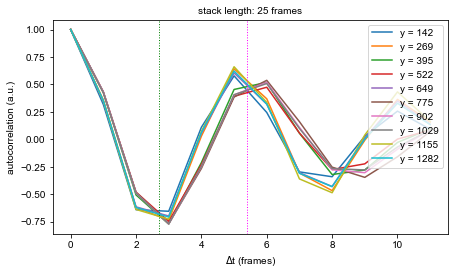

Analyzing t-y slices for x = [ 142  269  395  522  649  775  902 1029 1155 1282]

Position of first valley: (2.69 ± 0.13) frames
Oscillation period: (5.39 ± 0.27) frames



In [9]:
print("Original image stack:")
ref_period, ref_period_std, fig, ax = temporal_autocorrelation(
    Min_st, slices2analyze_x, slices2analyze_y
)
if save:
    fig.set_size_inches(9 * cm, 7 * cm)
    # ax.get_legend().remove()
    fig.tight_layout()
    fig.savefig(
        r"save_output\global_temporal_nonsmooth_full_results.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()

print("Smoothed image stack:")
smz_ref_period, smz_ref_period_std, fig, ax = temporal_autocorrelation(
    Min_st_smz, slices2analyze_x, slices2analyze_y
)
if save:
    fig.set_size_inches(9 * cm, 7 * cm)
    # ax.get_legend().remove()
    fig.tight_layout()
    fig.savefig(
        r"save_output\global_temporal_smooth_full_results.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()

### Temporal autocorrelation for cropped stacks
Next, crop the image stack further and perform the analysis again for every selected length (in frames).

In [10]:
periods_collect = []
periods_std_collect = []

smz_periods_collect = []
smz_periods_std_collect = []

for length in cut_off_lengths:

    print("Original image stack:")
    Min_st_new = Min_st[0:length, :, :]
    period, period_std, fig, ax = temporal_autocorrelation(
        Min_st_new, slices2analyze_x, slices2analyze_y
    )
    plt.show()
    periods_collect.append(period)
    periods_std_collect.append(period_std)

    print("Smoothed image stack:")
    Min_st_smz_new = Min_st_smz[0:length, :, :]
    period, period_std, fig, ax = temporal_autocorrelation(
        Min_st_smz_new, slices2analyze_x, slices2analyze_y
    )
    plt.show()
    smz_periods_collect.append(period)
    smz_periods_std_collect.append(period_std)

    clear_output(wait=False)
    plt.close("all")

## Results
Dashed lines indicate that no oscillation period could be determined.

periods_collect=[5.240418127657836, 5.296058355536309, 5.259093011796845, 5.395700894053158, 5.332227046087967, 5.293065912564922, nan]
smz_periods_collect=[5.411082787819681, 5.450365775806114, 5.412668123235642, 5.596842514716384, 5.397193825136478, nan, nan]


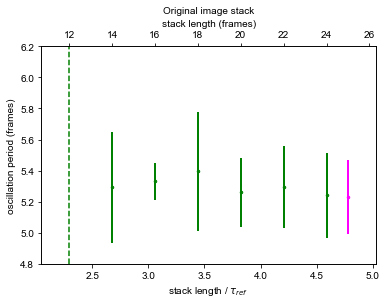

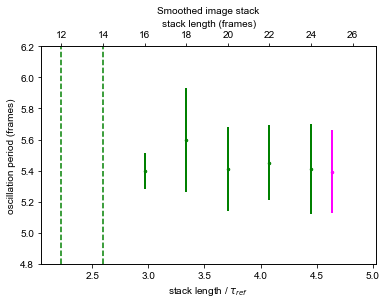

In [11]:
ymin = 4.8
ymax = 6.2

print(f"{periods_collect=}")
print(f"{smz_periods_collect=}")

fig, ax = plt.subplots()
ax_twin = ax.twiny()
ax.set_xlabel("stack length / $τ_{ref}$")
ax.set_ylim((ymin, ymax))
ax.set_ylabel("oscillation period (frames)")
ax.set_title("Original image stack", fontsize=10)
ax_twin.set_xlabel("stack length (frames)")

for n, length in enumerate(cut_off_lengths):
    period = periods_collect[n]
    period_std = periods_std_collect[n]
    if period > 0:
        ax.errorbar(
            (length / ref_period),
            period,
            yerr=period_std,
            marker=".",
            linewidth=2,
            markersize=5,
            color="green",
        )
    else:
        ax.vlines(
            x=(length / ref_period),
            ymin=ymin,
            ymax=ymax,
            color="green",
            linestyle="dashed",
        )

ax.errorbar(
    (nt / ref_period),
    ref_period,
    yerr=ref_period_std,
    marker=".",
    linewidth=2,
    markersize=5,
    color="magenta",
)

min_ax = min(cut_off_lengths) / ref_period - 0.25
max_ax = nt / ref_period + 0.25
ax.set_xlim((min_ax, max_ax))
ax_twin.set_xlim((min_ax * ref_period, max_ax * ref_period))

if save:
    fig.set_size_inches(9 * cm, 7 * cm)
    fig.tight_layout()
    fig.savefig(
        r"save_output\global_temporal_nonsmooth_collected_results.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()

fig2, ax2 = plt.subplots()
ax_twin2 = ax2.twiny()
ax2.set_xlabel("stack length / $τ_{ref}$")
ax2.set_ylim((ymin, ymax))
ax2.set_ylabel("oscillation period (frames)")
ax2.set_title("Smoothed image stack", fontsize=10)
ax_twin2.set_xlabel("stack length (frames)")

for n, length in enumerate(cut_off_lengths):
    period = smz_periods_collect[n]
    period_std = smz_periods_std_collect[n]
    if period > 0:
        ax2.errorbar(
            (length / smz_ref_period),
            period,
            yerr=period_std,
            marker=".",
            linewidth=2,
            markersize=5,
            color="green",
        )
    else:
        ax2.vlines(
            x=(length / smz_ref_period),
            ymin=ymin,
            ymax=ymax,
            color="green",
            linestyle="dashed",
        )

ax2.errorbar(
    (nt / smz_ref_period),
    smz_ref_period,
    yerr=smz_ref_period_std,
    marker=".",
    linewidth=2,
    markersize=5,
    color="magenta",
)

ax2.set_xlim((min_ax, max_ax))
ax_twin2.set_xlim((min_ax * smz_ref_period, max_ax * smz_ref_period))

if save:
    fig2.set_size_inches(9 * cm, 7 * cm)
    fig2.tight_layout()
    fig2.savefig(
        r"save_output\global_temporal_smooth_collected_results.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()